In [22]:
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest,  f_classif, chi2, f_regression

import pandas as pd
import geopandas as gpd
import numpy  as np

from tobler.area_weighted import area_interpolate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import statsmodels.api as sm

# Plotting
import matplotlib as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [23]:
# Shape file of State of Kansas
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp' # state shape file. 
kansas = gpd.read_file(fp)
ks_map = kansas.NAME.isin(['Kansas']) 
ks_map = kansas[ks_map].loc[0:]
ks_map.to_crs(epsg=4326, inplace=True)

# County shape file, use for county lines
fp= 'C:/Users/sarahann.USERS/Desktop/code/us_county/US_County_Boundaries.shp' # county file

map_county = gpd.read_file(fp)
# Delete Non-contingous US counties 
ks_county = map_county.STATE.isin(['Kansas'])  
map_county = map_county[ks_county].loc[0:]
map_county.to_crs(epsg=4326, inplace=True)

cluster = gpd.read_file( 'C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/cluster.shp')
cluster.set_crs(epsg=4326, inplace=True)
cluster.head(3)

,cluster,geometry
0,12.0,"POLYGON ((-100.08750 39.99583, -100.07083 39.9..."
1,12.0,"POLYGON ((-100.02917 39.99583, -100.00417 39.9..."
2,12.0,"POLYGON ((-99.42917 39.99583, -99.42083 39.995..."


In [24]:
cluster['cluster'].replace(0, np.NaN, inplace=True)
cluster['macro'] = cluster.cluster //10
cluster['micro'] = cluster.cluster - (cluster.macro *10)
cluster = cluster.loc[cluster[~cluster.isnull().any(axis=1)].index]
cluster.head(3)

,cluster,geometry,macro,micro
0,12.0,"POLYGON ((-100.08750 39.99583, -100.07083 39.9...",1.0,2.0
1,12.0,"POLYGON ((-100.02917 39.99583, -100.00417 39.9...",1.0,2.0
2,12.0,"POLYGON ((-99.42917 39.99583, -99.42083 39.995...",1.0,2.0


**Look at crop indemnity - liability ratio**

In [25]:
liab_ratio_by_crop= gpd.read_file('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/liab_ratio_by_crop.shape/liab_ratio_by_crop.shp')
liab_ratio_by_crop.to_crs(epsg=4326, inplace=True)
print(liab_ratio_by_crop.columns.unique())
liab_ratio_by_crop.head()

Index(['STFIPS', 'CTFIPS', 'STATE', 'COUNTY', 'VERSION', 'Shape_Leng',
       'Shape_Area', 'Annual For', 'Barley', 'Canola', 'Corn', 'Cotton',
       'Dry Beans', 'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet',
       'Oats', 'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame',
       'Silage Sor', 'Soybeans', 'Sunflowers', 'Triticale', 'Wheat',
       'geometry'],
      dtype='object')


,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,Annual For,Barley,Canola,...,"Pasture,Ra",Potatoes,Rye,Sesame,Silage Sor,Soybeans,Sunflowers,Triticale,Wheat,geometry
0,20,20023,Kansas,cheyenne,05,2.145800,0.277993,0.331577,0.117000,NaN,...,0.236326,NaN,NaN,NaN,NaN,0.032165,0.077457,NaN,0.059602,"POLYGON ((-102.04981 39.57406, -102.04993 39.5..."
1,20,20153,Kansas,rawlins,05,2.213924,0.291303,0.283451,0.358995,NaN,...,0.236017,NaN,NaN,NaN,NaN,0.088354,0.050865,NaN,0.052791,"POLYGON ((-101.41391 39.56832, -101.41361 39.5..."
2,20,20089,Kansas,jewell,05,2.016403,0.249024,NaN,0.038528,NaN,...,0.152374,NaN,NaN,NaN,NaN,0.026751,0.095459,NaN,0.052105,"POLYGON ((-98.50527 39.56760, -98.50530 39.567..."
3,20,20183,Kansas,smith,05,1.992673,0.244139,NaN,NaN,NaN,...,0.117586,NaN,NaN,NaN,0.017509,0.025075,0.000000,NaN,0.043569,"POLYGON ((-99.04409 39.56786, -99.04429 39.567..."
4,20,20147,Kansas,phillips,05,1.990133,0.243669,NaN,NaN,NaN,...,0.139701,NaN,NaN,NaN,0.000000,0.035938,0.035199,NaN,0.028248,"POLYGON ((-99.62795 39.56744, -99.62777 39.573..."


In [26]:
# Crops with missing county value
liab_ratio_by_crop.isna().sum()

STFIPS          0
CTFIPS          0
STATE           0
COUNTY          0
VERSION         0
Shape_Leng      0
Shape_Area      0
Annual For     64
Barley         73
Canola         94
Corn            0
Cotton         78
Dry Beans      98
Dry Peas      103
Grain Sorg      1
Hemp          104
Hybrid Sor    102
Millet         97
Oats           50
Onions        104
Pasture,Ra      1
Potatoes      101
Rye           104
Sesame        102
Silage Sor     72
Soybeans        1
Sunflowers     47
Triticale      85
Wheat           0
geometry        0
dtype: int64

In [27]:
# Imput 0 for the liability ratio for crops w/out a value
liab_ratio_by_crop.fillna(0, inplace=True)

In [28]:
liab_ratio_by_crop = area_interpolate(source_df= liab_ratio_by_crop, target_df= cluster , intensive_variables=['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton',
       'Dry Beans', 'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet',
       'Oats', 'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame',
       'Silage Sor', 'Soybeans', 'Sunflowers', 'Triticale', 'Wheat'])

liab_ratio_by_crop=liab_ratio_by_crop.merge(cluster, on='geometry')
print(liab_ratio_by_crop.columns.unique())

liab_ratio_by_crop.head()

<ipython-input-28-d45dd9d53d8e>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  liab_ratio_by_crop = area_interpolate(source_df= liab_ratio_by_crop, target_df= cluster , intensive_variables=['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton',
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\tobler\area_weighted\area_interpolate.py:362: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  den = source_df[source_df.geometry.name].area.values


Index(['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton', 'Dry Beans',
       'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet', 'Oats',
       'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame', 'Silage Sor',
       'Soybeans', 'Sunflowers', 'Triticale', 'Wheat', 'geometry', 'cluster',
       'macro', 'micro'],
      dtype='object')


,Annual For,Barley,Canola,Corn,Cotton,Dry Beans,Dry Peas,Grain Sorg,Hemp,Hybrid Sor,...,Sesame,Silage Sor,Soybeans,Sunflowers,Triticale,Wheat,geometry,cluster,macro,micro
0,0.0,0.110627,0.0,0.033498,0.0,0.0,0.0,0.087623,0.0,0.0,...,0.0,0.065548,0.047633,0.000000,0.0,0.046677,"POLYGON ((-100.08750 39.99583, -100.07083 39.9...",12.0,1.0,2.0
1,0.0,0.110627,0.0,0.033498,0.0,0.0,0.0,0.087623,0.0,0.0,...,0.0,0.065548,0.047633,0.000000,0.0,0.046677,"POLYGON ((-100.02917 39.99583, -100.00417 39.9...",12.0,1.0,2.0
2,0.0,0.000000,0.0,0.009191,0.0,0.0,0.0,0.035772,0.0,0.0,...,0.0,0.000000,0.035938,0.035199,0.0,0.028248,"POLYGON ((-99.42917 39.99583, -99.42083 39.995...",12.0,1.0,2.0
3,0.0,0.000000,0.0,0.009778,0.0,0.0,0.0,0.030563,0.0,0.0,...,0.0,0.017509,0.025075,0.000000,0.0,0.043569,"POLYGON ((-98.77083 39.99583, -98.74583 39.995...",12.0,1.0,2.0
4,0.0,0.000000,0.0,0.009778,0.0,0.0,0.0,0.030563,0.0,0.0,...,0.0,0.017509,0.025075,0.000000,0.0,0.043569,"POLYGON ((-98.71250 39.99583, -98.70417 39.995...",12.0,1.0,2.0


In [80]:
"""
'Annual For', 'Barley',  'Dry Beans', 'Dry Peas', 'Hemp', 'Hybrid Sor', 'Millet', 'Oats', 'Onions', 'Potatoes', 'Rye', 'Sesame',  'Silage Sor', 'Triticale',

# Remove crops that have >= 50 nan values, equivalent to 50 counties without observed data point
Annual For     64
Barley         73
Canola         94
Corn            0
Cotton         78
Dry Beans      98
Dry Peas      103
Grain Sorg      1
Hemp          104
Hybrid Sor    102
Millet         97
Oats           50
Onions        104
Pasture,Ra      1
Potatoes      101
Rye           104
Sesame        102
Silage Sor     72
Soybeans        1
Sunflowers     47
Triticale      85
Wheat           0
"""
names = ['Corn', 'Cotton', 'Canola',
        'Grain Sorg',  'Pasture,Ra', 'Oats', 
        'Soybeans', 'Sunflowers',  'Wheat']

X = liab_ratio_by_crop[names]

y = liab_ratio_by_crop['macro'].astype("category")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

logmodel = LogisticRegression(multi_class='multinomial', solver='lbfgs') 
logmodel.fit(X_train, y_train)
predictions_log=logmodel.predict(X_test)

print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

         1.0       0.78      0.29      0.42        49
         2.0       0.88      0.95      0.91       416
         3.0       0.78      0.75      0.77        96

    accuracy                           0.86       561
   macro avg       0.81      0.66      0.70       561
weighted avg       0.85      0.86      0.84       561



<AxesSubplot:title={'center':'NW Kansas'}>

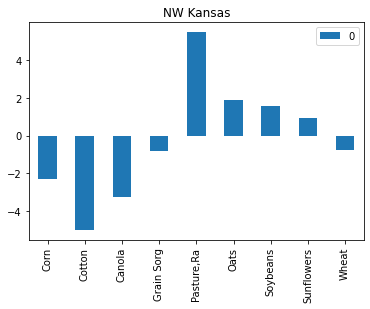

In [9]:
importance= logmodel.coef_
cls_1_features = pd.DataFrame(importance[0], index=names)
pd.DataFrame(importance[0], index=names).plot.bar(title = 'NW Kansas')

<AxesSubplot:title={'center':'E Kansas'}>

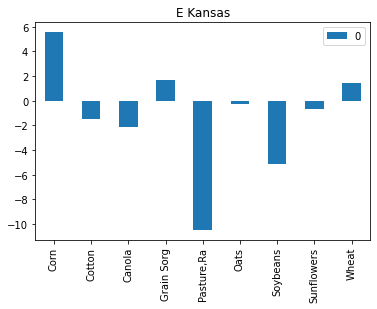

In [10]:
pd.DataFrame(importance[1], index=names).plot.bar(title = 'E Kansas')

<AxesSubplot:title={'center':'SW Kansas'}>

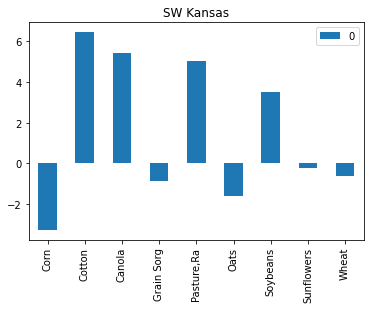

In [11]:
pd.DataFrame(importance[2], index=names).plot.bar(title = 'SW Kansas')

In [12]:
# Convert all the 0 values back to nan so not to include in the mean summary
liab_ratio_by_crop.replace(0, np.nan, inplace=True)

uni_cls = liab_ratio_by_crop.groupby(['macro'], dropna=True).mean()
uni_cls['cluster'] = [11, 12, 13]
uni_cls=uni_cls.reset_index()
uni_cls.head(3)

In [48]:
# This is not used, as dissolve does not support calculating mean and ignoring nan, the dataframe is adjusted above, renamed and added cluster to align with code below
uni_cls=liab_ratio_by_crop.dissolve(by='cluster', aggfunc = 'mean', dropna=False)
uni_cls=uni_cls.reset_index()
uni_cls.head(3)

,cluster,geometry,Annual For,Barley,Canola,Corn,Cotton,Dry Beans,Dry Peas,Grain Sorg,...,Potatoes,Rye,Sesame,Silage Sor,Soybeans,Sunflowers,Triticale,Wheat,macro,micro
0,11.0,"MULTIPOLYGON (((-102.03750 37.87917, -102.0375...",0.189241,0.147893,0.00000,0.070768,0.002796,0.018550,0.002279,0.079321,...,0.0,0.0,0.0,0.077336,0.055087,0.088481,0.055057,0.085412,1.0,1.0
1,12.0,"MULTIPOLYGON (((-101.84583 37.88750, -101.8291...",0.125552,0.101510,0.00000,0.054837,0.000714,0.016316,0.007569,0.058453,...,0.0,0.0,0.0,0.057072,0.070602,0.083913,0.018195,0.066850,1.0,2.0
2,21.0,"MULTIPOLYGON (((-97.62083 37.31250, -97.62083 ...",0.022657,0.027823,0.01616,0.075265,0.032836,0.000000,0.000000,0.090260,...,0.0,0.0,0.0,0.000000,0.040283,0.059390,0.000000,0.087761,2.0,1.0


In [53]:
uni_cls = uni_cls.groupby(['macro'], dropna=True).mean()
uni_cls['cluster'] = [11, 12, 13]
uni_cls

,cluster,Annual For,Barley,Canola,Corn,Cotton,Dry Beans,Dry Peas,Grain Sorg,Hemp,...,"Pasture,Ra",Potatoes,Rye,Sesame,Silage Sor,Soybeans,Sunflowers,Triticale,Wheat,micro
macro,,,,,,,,,,,,,,,,,,,,,
1.0,11,0.157397,0.124702,0.000000,0.062803,0.001755,0.017433,0.004924,0.068887,0.104754,...,0.166086,0.000000,0.000000,0.000000,0.067204,0.062844,0.086197,0.036626,0.076131,1.5
2.0,12,0.029420,0.025479,0.020839,0.075772,0.029790,0.000000,0.000000,0.087387,0.002626,...,0.097096,0.000000,0.000000,0.000000,0.000000,0.040004,0.051525,0.000000,0.093051,1.5
3.0,13,0.102528,0.032425,0.186206,0.048648,0.156568,0.000000,0.000000,0.074608,0.000000,...,0.132571,0.000436,0.005519,0.013041,0.009656,0.060766,0.099738,0.035300,0.063799,1.5


In [60]:
uni_cls[names]*100

,Corn,Cotton,Canola,Grain Sorg,"Pasture,Ra",Oats,Soybeans,Sunflowers,Wheat
macro,,,,,,,,,
1.0,6.280258,0.175484,0.000000,6.888687,16.608614,11.107261,6.284438,8.619701,7.613082
2.0,7.577217,2.979020,2.083893,8.738691,9.709567,6.433925,4.000410,5.152464,9.305108
3.0,4.864823,15.656795,18.620629,7.460774,13.257054,5.218983,6.076571,9.973759,6.379922


In [58]:
names

['Corn',
 'Cotton',
 'Canola',
 'Grain Sorg',
 'Pasture,Ra',
 'Oats',
 'Soybeans',
 'Sunflowers',
 'Wheat']

In [54]:
crop_columns = names # names used in the multinomial above
categories =  names 
categories = [*categories, categories[0]]

In [55]:
[cls_1_1]=uni_cls.loc[uni_cls.cluster == 11][crop_columns].values.tolist()
[cls_1_2]=uni_cls.loc[uni_cls.cluster ==12][crop_columns].values.tolist()
[cls_1_3]=uni_cls.loc[uni_cls.cluster ==13][crop_columns].values.tolist()

Cluster_1 = [*cls_1_1, cls_1_1[0]]
Cluster_2 = [*cls_1_2, cls_1_2[0]]
Cluster_3 = [*cls_1_3, cls_1_3[0]]


In [56]:
crop_columns

['Corn',
 'Cotton',
 'Canola',
 'Grain Sorg',
 'Pasture,Ra',
 'Oats',
 'Soybeans',
 'Sunflowers',
 'Wheat']

In [ ]:
Cluster_1

In [ ]:
Cluster_2

In [40]:
categories[4] = 'Pasture'
categories[3] = 'Sorghum'

In [41]:
label_loc

array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531])

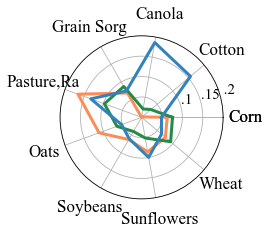

In [57]:
plt.figure(figsize=(3,3))
ax = plt.subplot(111, polar=True)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] =17


categories = crop_columns
categories = [*categories, categories[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

plt.plot(label_loc, Cluster_1, label='Zone 1. NW KS', color='#fc8d59', linewidth=3)
plt.plot(label_loc, Cluster_2, label='Zone 2. E KS', color = "#238b45", linewidth=3)
plt.plot(label_loc, Cluster_3, label='Zone 3. SW KS', color =  '#3182bd', linewidth=3)

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)

plt.yticks([0.05, .1, .15, .2], ["",".1",".15", ' .2'], color="black", size=15)

ax.tick_params(pad=12)
#ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(3.5, .2), frameon=False)
ax.set_rlabel_position(15)

plt.savefig('ILR.png', bbox_inches = 'tight', dpi=500)

plt.show()

In [45]:
Cluster_3

[0.04881927597454744,
 0.17580912495830153,
 0.3356822997195704,
 0.07506792217129844,
 0.13267059844704163,
 0.24658898458561862,
 0.062227877231207304,
 0.17670128639960433,
 0.06405886765053939,
 0.04881927597454744]

In [ ]:
plt.figure(figsize=(3,3))
ax = plt.subplot(111, polar=True)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] =35

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

plt.plot(label_loc, Cluster_1, label='Zone 1. NW KS', color='#fc8d59', linewidth=3)
plt.plot(label_loc, Cluster_2, label='Zone 2. E KS', color = "#238b45", linewidth=3)
plt.plot(label_loc, Cluster_3, label='Zone 3. SW KS', color =  '#3182bd', linewidth=3)

lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)

plt.yticks([0.05, .1, .15, .2], ["",".1",".15", ' .2'], color="black", size=15)

ax.tick_params(pad=12)
ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(3.5, -.2), frameon=False)
ax.set_rlabel_position(15)

#plt.savefig('legend_labels.png', bbox_inches = 'tight', dpi=700)

plt.show()